In [82]:
from Parser import parse_frames
from scipy.signal import medfilt
import numpy as np
import math
import glob
import os
import matplotlib.pyplot as plt

# Need a folder with npy compressed files of videos


Processing...
Video from folder: output_points_bicep_correct2
Detected arm: left


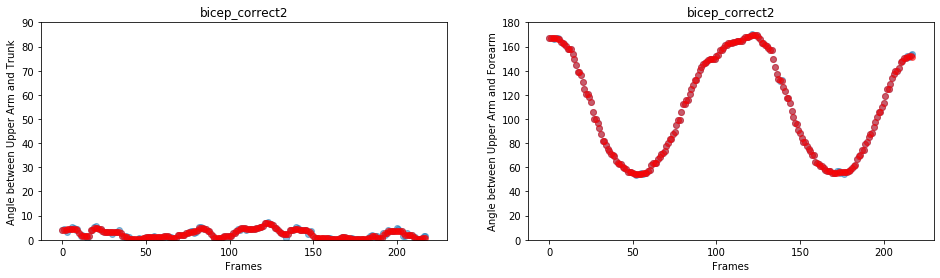

Angles between upper arm and trunk
Max angle: 7.227155781544673
Min angle: 0.018051453078769413


Angles between upper arm and forearm
Max angle: 170.04799868977017
Min angle: 53.89455241712745


Processing...
Video from folder: output_points_bicep_correct3
Detected arm: right


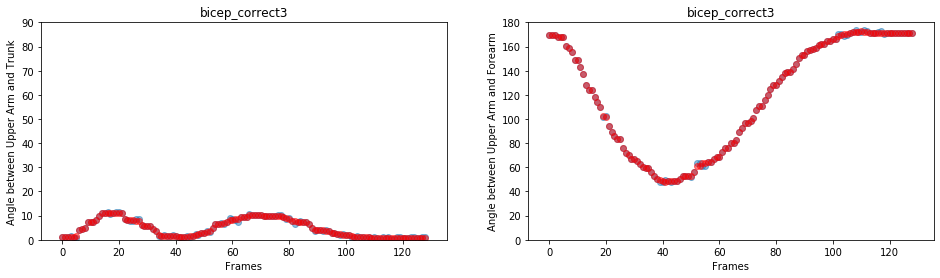

Angles between upper arm and trunk
Max angle: 11.478157689834383
Min angle: 0.13712241465863856


Angles between upper arm and forearm
Max angle: 173.50594170709155
Min angle: 48.225788027066095


Processing...
Video from folder: output_points_bicep_front
Detected arm: left


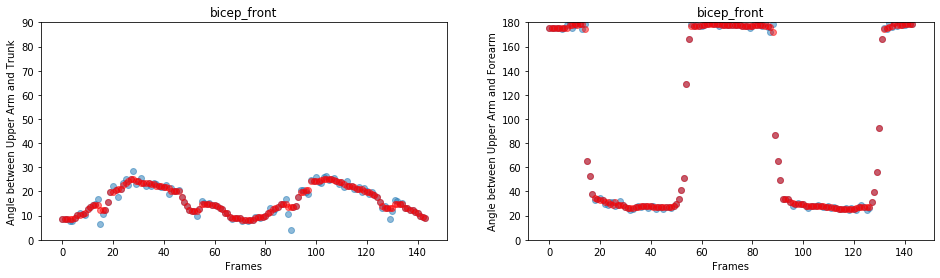

Angles between upper arm and trunk
Max angle: 28.51384271289613
Min angle: 4.171598749729716


Angles between upper arm and forearm
Max angle: 179.9427429628122
Min angle: 24.806617234773512




In [85]:
# modify this path for other videos 
# input_folder = "/home/aleko/Documents/Projects/IndividualProject/bicepvid"
input_folder = "C:\\Users\\ak5u16\\Desktop\\IProject\\openpose"
folder_paths = glob.glob(os.path.join(input_folder, 'output_points_bicep*'))

# Return unit vector
def unit_vector(vect):
    return vect / np.linalg.norm(vect)

# Calcute angle between vectors
def calc_angle(vect1, vect2):
    unit_vect1 = unit_vector(vect1)
    unit_vect2 = unit_vector(vect2)
    return math.degrees(np.arccos(np.clip(np.dot(unit_vect1, unit_vect2), -1.0, 1.0)))

# Detecting sides (left or right) on videos  
# can use this method for other exercises
def detect_side(frame_poses):
    side = ''
    rside_joints = [pose.joint_keypoints['RSHOULDER'] + pose.joint_keypoints['RELBOW'] + pose.joint_keypoints['RWRIST'] for pose in frame_poses 
                    if pose.joint_keypoints['RSHOULDER'][2]!=0 and pose.joint_keypoints['RELBOW'][2]!=0 and pose.joint_keypoints['RWRIST'][2]!=0]
    
    lside_joints = [pose.joint_keypoints['LSHOULDER'] + pose.joint_keypoints['LELBOW'] + pose.joint_keypoints['LWRIST'] for pose in frame_poses 
                    if pose.joint_keypoints['LSHOULDER'][2]!=0 and pose.joint_keypoints['LELBOW'][2]!=0 and pose.joint_keypoints['LWRIST'][2]!=0]
    
    # think about the case when they are equal
    if len(rside_joints) > len(lside_joints): 
        side = 'right'
    else: 
        side = 'left'
    
    return side
    
    
for folder in folder_paths:
    video_name = os.path.basename(folder).replace('output_points_', '')
    frame_poses = parse_frames(folder)
                        
    # Computing angles
    trunk_vects = []
    upArm_forearm_angles = [] 
    upArm_trunk_angles = []
    upArm_vects = []
    forearm_vects = []
    upArm_vects = []
    forearm_vects = []
    
    # Detect side
    side = detect_side(frame_poses)
    print('Detected arm: ' + side)

    for posture in frame_poses:
        if side == 'right':
            parts = [posture.joint_keypoints['RSHOULDER'], posture.joint_keypoints['RELBOW'], posture.joint_keypoints['RWRIST']]
        else: 
            parts = [posture.joint_keypoints['LSHOULDER'], posture.joint_keypoints['LELBOW'], posture.joint_keypoints['LWRIST']]

        # upper arm 
        # [0]- x; [1] - y, [2] - c
        upArm_vect = [parts[0][0] - parts[1][0], parts[0][1] - parts[1][1]]
        upArm_vects.append(upArm_vect)
                 
        # trunk
        trunk_vect = [posture.joint_keypoints['NECK'][0] - posture.joint_keypoints['MIDHIP'][0], posture.joint_keypoints['NECK'][1] - posture.joint_keypoints['MIDHIP'][1]]
        trunk_vects.append(trunk_vect)
        # Calculate upper arm and trunk angle
        # convert to unit vectors
        upArm_vect = unit_vector(upArm_vect)
        trunk_vect = unit_vector(trunk_vect)

        # Calculate angle and add to list
        upArm_trunk_angles.append(calc_angle(upArm_vect, trunk_vect))

        # forearm
        forearm_vect = [parts[2][0] - parts[1][0], parts[2][1] - parts[1][1]]
        forearm_vects.append(forearm_vect)
        # Calculate upper arm and forearm angle 
        forearm_vect = unit_vector(forearm_vect)
        upArm_forearm_angles.append(calc_angle(upArm_vect, forearm_vect))


    # for now use medfilt
    # might use Kalman filter or something later instead
    upArm_vects = np.array(upArm_vects)
    trunk_vects = np.array(trunk_vects)
    upArm_trunk_angles = np.array(upArm_trunk_angles)
    upArm_trunk_angles_filtered = medfilt(upArm_trunk_angles, 5)
    upArm_trunk_angles_filtered = medfilt(upArm_trunk_angles_filtered, 5)
    upArm_forearm_angles = np.array(upArm_forearm_angles)
    upArm_forearm_angles_filtered = medfilt(upArm_forearm_angles, 5)
    upArm_forearm_angles_filtered = medfilt(upArm_forearm_angles, 5)

    # Plot
    plt.figure(figsize=(16,4))

    plt.subplot(1, 2, 1)
    plt.scatter(np.arange(upArm_trunk_angles.shape[0]), upArm_trunk_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Trunk')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,90) 

    plt.subplot(1, 2, 2)
    plt.scatter(np.arange(upArm_forearm_angles.shape[0]),upArm_forearm_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]),upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Forearm')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,180) 
    plt.show()


    print("Angles between upper arm and trunk\nMax angle: " + str(np.max(upArm_trunk_angles)) + "\nMin angle: " + str(np.min(upArm_trunk_angles)))
    print('\n')
    print("Angles between upper arm and forearm\nMax angle: " + str(np.max(upArm_forearm_angles)) + "\nMin angle: " + str(np.min(upArm_forearm_angles)))
    print('\n' + '='*120 + '\n')